In [1]:
import zipfile # gz format is not supported by Pandas
import urllib
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline

# 1. Data acquisition

In [2]:
#data path
apple_mobility_path = 'wiki_pageviews_covid/data/applemobilitytrends-2020-04-20.csv.gz'
Global_mobility_path = 'wiki_pageviews_covid/data/Global_Mobility_Report.csv.gz'
aggregate_timeseries_path = 'wiki_pageviews_covid/data/aggregated_timeseries.json.gz'
topics_linked_path = 'wiki_pageviews_covid/data/topics_linked.csv.xz'
interventions_path = 'wiki_pageviews_covid/data/interventions.csv'

Global_mobility = pd.read_csv(Global_mobility_path,compression = 'gzip')
apple_mobility = pd.read_csv(apple_mobility_path,compression='gzip')
interventions = pd.read_csv(interventions_path)



C:\Users\whh\AppData\Local\Temp\ipykernel_6252\703340118.py:8: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  Global_mobility = pd.read_csv(Global_mobility_path,compression = 'gzip')


# 2. Data preprocessing and overview    
1) Analyse the scale of the dataset and missing value  
2) Conduct preliminary visualisation such as plotting the time series of mobility shift of different countries

## 2.1 For inverventions.csv

In [3]:
interventions.head()

,lang,1st case,1st death,School closure,Public events banned,Lockdown,Mobility,Normalcy
0,fr,2020-01-24,2020-02-14,2020-03-14,2020-03-13,2020-03-17,2020-03-16,2020-07-02
1,da,2020-02-27,2020-03-12,2020-03-13,2020-03-12,2020-03-18,2020-03-11,2020-06-05
2,de,2020-01-27,2020-03-09,2020-03-14,2020-03-22,2020-03-22,2020-03-16,2020-07-10
3,it,2020-01-31,2020-02-22,2020-03-05,2020-03-09,2020-03-11,2020-03-11,2020-06-26
4,nl,2020-02-27,2020-03-06,2020-03-11,2020-03-24,NaN,2020-03-16,2020-05-29


In [4]:
# Correspondence between countries and their first official language
lang_coun=[['fr','France'],['da','Denmark'],['de','Germany'],['it','Italy'],['nl','Netherlands'],['no','Norway'],['sr','Serbia'],['sv','Sweden'],['ko','Republic of Korea'],['ca','Andorra'],['fi','Finland'],['ja','Japan']]
lang_country=pd.DataFrame(lang_coun,columns=['Language','Country'])

# Replace the languange in interventions as country name
interventions.drop(interventions.index[[-1]], axis = 0, inplace = True)#drop the last row for too many missing values
interventions=interventions.join(lang_country, lsuffix="_left", rsuffix="_right", how='outer')
interventions.drop('Language', inplace=True, axis=1)
interventions.drop('lang', inplace=True, axis=1)

#change the column lang to match and cross analyse with other dataset
interventions['Country'] = interventions['Country'].str.upper()
interventions = interventions.set_index('Country')

# Calculate the time-interval between first death and lockdown
interventions = pd.to_datetime(interventions.stack(),format = '%Y-%m-%d').unstack()
interventions['response_days'] = (interventions['School closure'] - interventions['1st death']).dt.days
interventions['response_days'] = interventions['response_days'].astype('int')
interventions = interventions.sort_values(by='response_days', ascending=True)
interventions


,1st case,1st death,School closure,Public events banned,Lockdown,Mobility,Normalcy,response_days
Country,,,,,,,,
SERBIA,2020-03-06,2020-03-20,2020-03-15,2020-03-21,2020-03-21,2020-03-16,2020-05-02,-5
FINLAND,2020-01-29,2020-03-21,2020-03-16,2020-03-16,NaT,2020-03-16,2020-05-21,-5
DENMARK,2020-02-27,2020-03-12,2020-03-13,2020-03-12,2020-03-18,2020-03-11,2020-06-05,1
REPUBLIC OF KOREA,2020-01-20,2020-02-20,2020-02-23,NaT,NaT,2020-02-25,2020-04-15,3
GERMANY,2020-01-27,2020-03-09,2020-03-14,2020-03-22,2020-03-22,2020-03-16,2020-07-10,5
NETHERLANDS,2020-02-27,2020-03-06,2020-03-11,2020-03-24,NaT,2020-03-16,2020-05-29,5
SWEDEN,2020-01-31,2020-03-11,2020-03-18,2020-03-12,NaT,2020-03-11,2020-06-05,7
ITALY,2020-01-31,2020-02-22,2020-03-05,2020-03-09,2020-03-11,2020-03-11,2020-06-26,12
JAPAN,2020-01-16,2020-02-13,2020-02-27,2020-02-25,NaT,2020-03-31,2020-06-14,14


In [5]:
import plotly.express as px
fig = px.timeline(interventions.iloc[:,[1,2,7]], color = 'response_days', x_start="1st death", x_end="School closure", y= interventions.index)
fig.update_yaxes(autorange="reversed") # otherwise tasks are listed from the bottom up
fig.show()

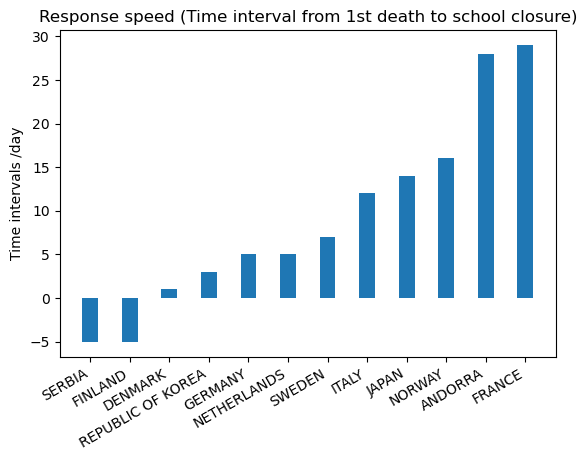

In [6]:
#Draw a barchart for time interval between 1st death and school closure in different countries
x_axis = interventions.index
y_death_event = interventions['response_days']
fig = plt.figure()
plt.bar(x_axis, y_death_event, width=0.4)

#plt.xticks(x_axis,rotation = 45)
plt.title('Response speed (Time interval from 1st death to school closure)')
#plt.xlabel('Country')
plt.ylabel('Time intervals /day')
fig.autofmt_xdate()
plt.show()

## 2.2 For Global_Mobility_Report.csv

In [7]:
Global_mobility.head()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0


<AxesSubplot:>

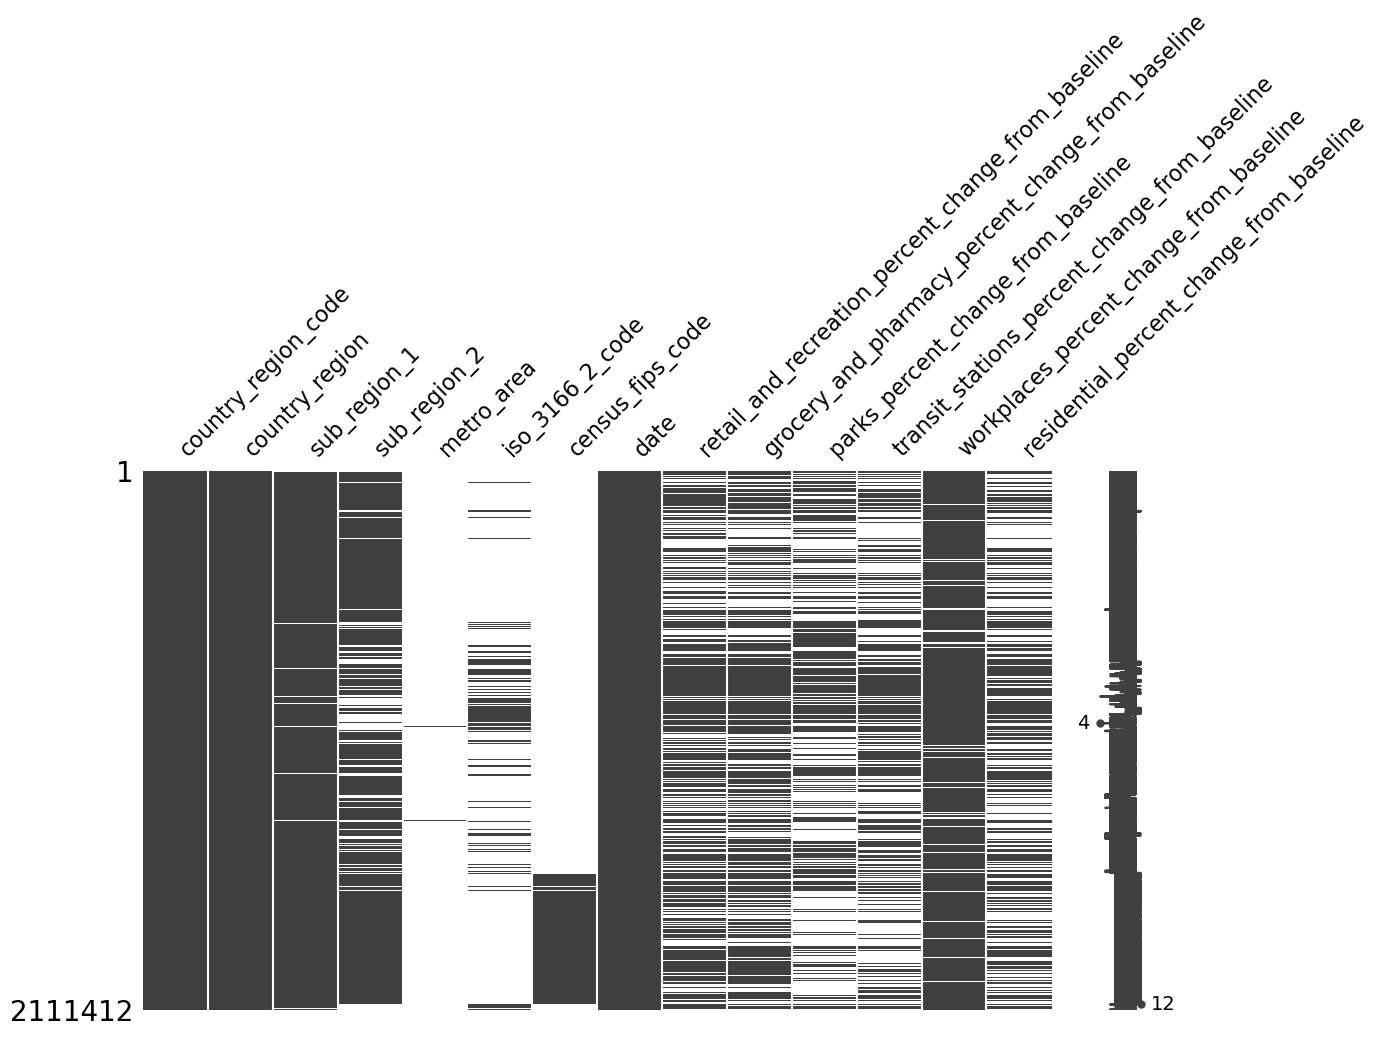

In [8]:
import missingno as msno
msno.matrix(Global_mobility,figsize=(13, 7))

In [9]:
# proportion of null value of each column
Global_mobility.isna().sum()/Global_mobility.shape[0]

country_region_code                                   0.000709
country_region                                        0.000000
sub_region_1                                          0.018154
sub_region_2                                          0.180897
metro_area                                            0.994122
iso_3166_2_code                                       0.813653
census_fips_code                                      0.762436
date                                                  0.000000
retail_and_recreation_percent_change_from_baseline    0.363799
grocery_and_pharmacy_percent_change_from_baseline     0.373900
parks_percent_change_from_baseline                    0.536971
transit_stations_percent_change_from_baseline         0.502960
workplaces_percent_change_from_baseline               0.050385
residential_percent_change_from_baseline              0.499080
dtype: float64

We observe that the value missing of this dataset is significant and should be handled with caution. For example, the missing value percentage of parks_percent_change_from_baseline is over 50%, which could be problematic for further analysis.

In [10]:
# check the consistency between ['country_region_code'] and ['country_region']
for x in Global_mobility['country_region_code'].unique():
    mask = Global_mobility['country_region_code']==x
    l = Global_mobility[mask].country_region.nunique()
    if l != 1:
        raise ValueError('The code is '+str(x))

ValueError: The code is nan

In [11]:
# replace the code of Namibia as 'NA'
Global_mobility.loc[Global_mobility['country_region']=='Namibia', 'country_region_code'] = 'NA'

In [12]:
# check the consistency between ['country_region_code'] and ['country_region']
for x in Global_mobility['country_region_code'].unique():
    mask = Global_mobility['country_region_code']==x
    l = Global_mobility[mask].country_region.nunique()
    if l != 1:
        raise ValueError('The code is '+str(x))

In [13]:
Global_mobility.isna().any()

country_region_code                                   False
country_region                                        False
sub_region_1                                           True
sub_region_2                                           True
metro_area                                             True
iso_3166_2_code                                        True
census_fips_code                                       True
date                                                  False
retail_and_recreation_percent_change_from_baseline     True
grocery_and_pharmacy_percent_change_from_baseline      True
parks_percent_change_from_baseline                     True
transit_stations_percent_change_from_baseline          True
workplaces_percent_change_from_baseline                True
residential_percent_change_from_baseline               True
dtype: bool

Now the country_region_code and country_region match perfectly.

Here we could plot the mobility active of the countries included in interventions. The intuition is that we try to analyse the correlation of mobility shift and government intervention which require to coanalyse both datasets. We start with workplaces_percent_change_from_baseline given it has much less missing values compared with others.

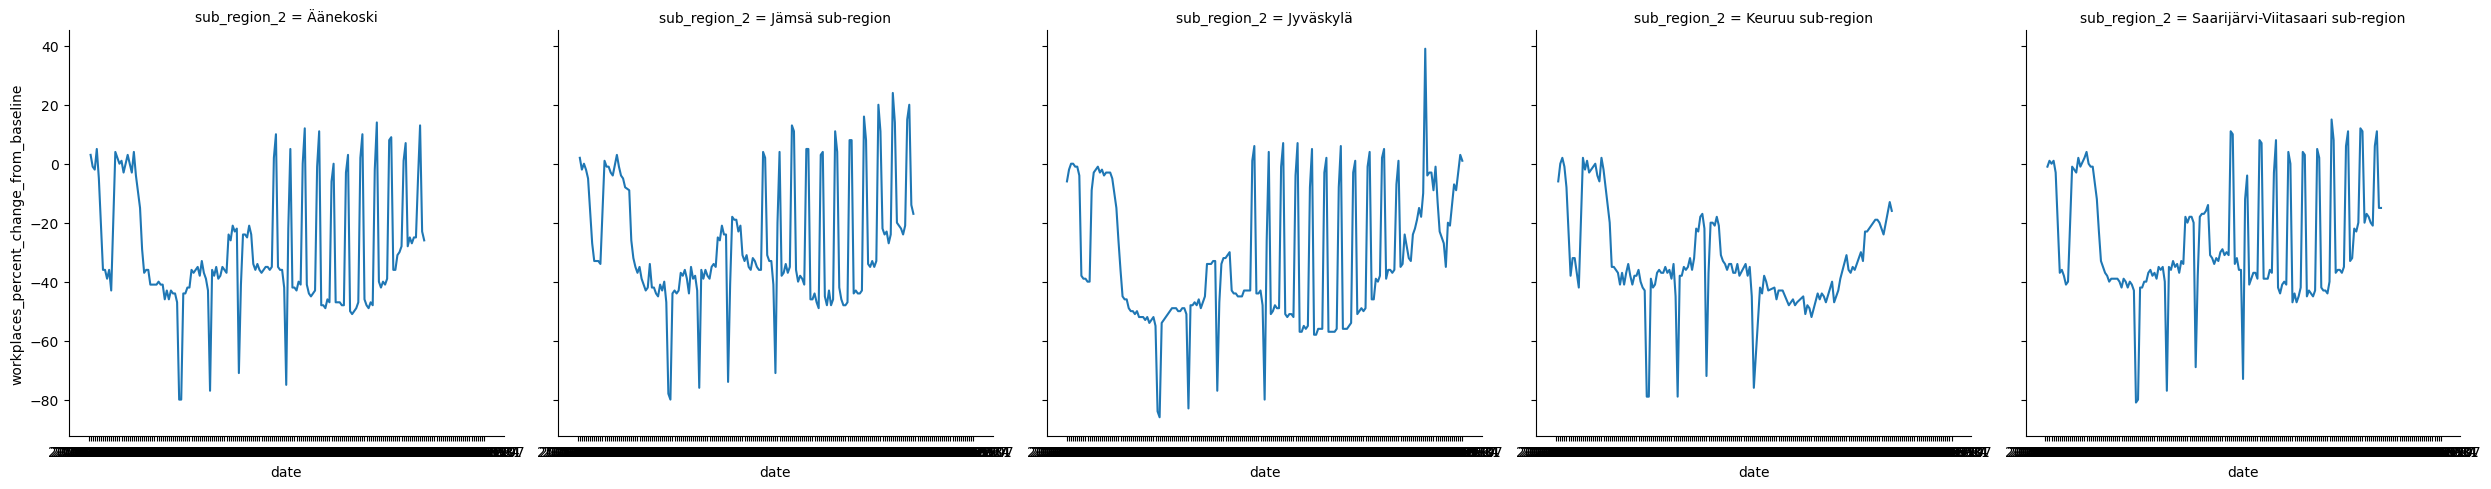

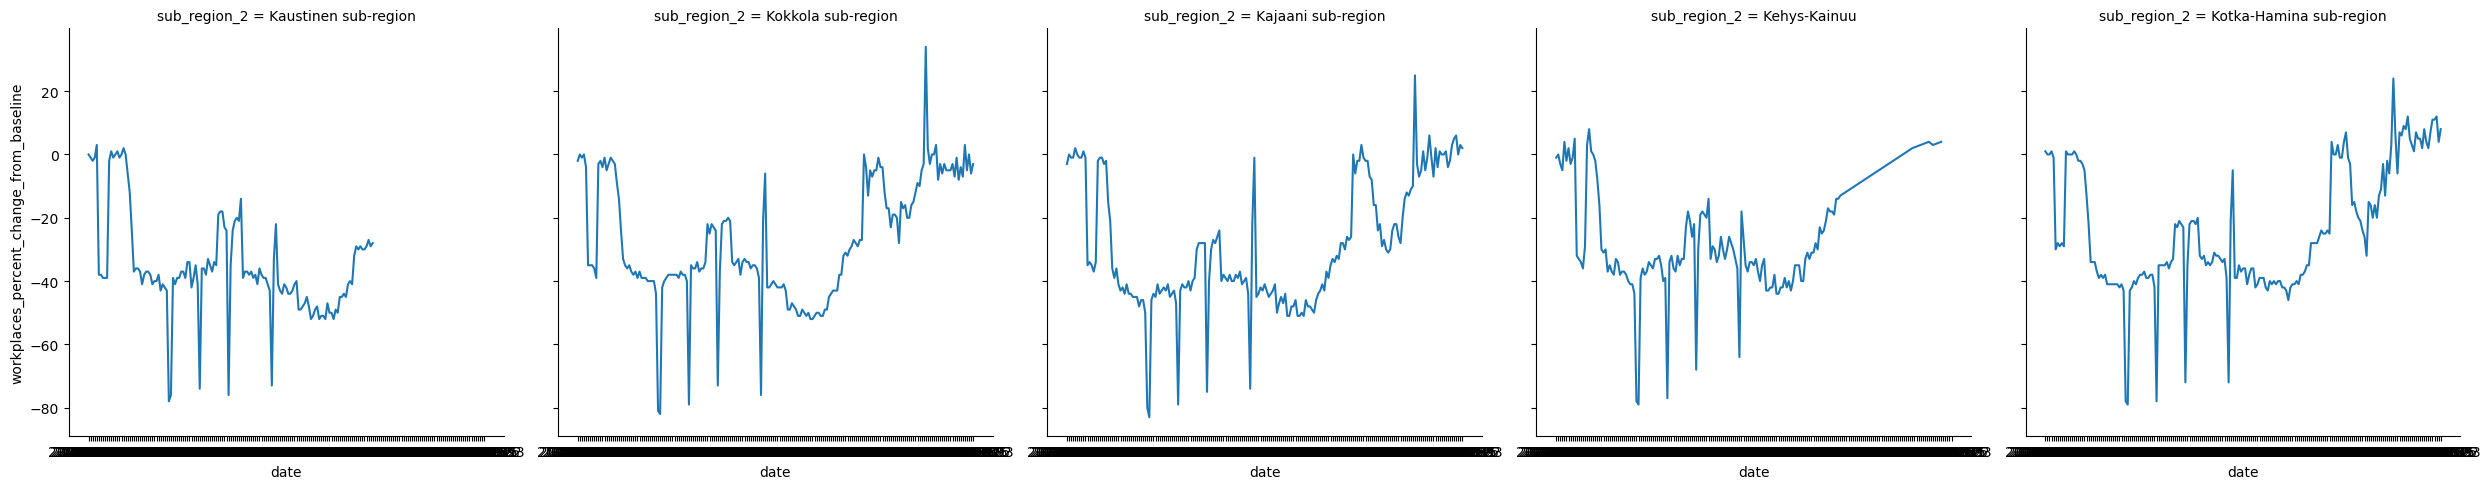

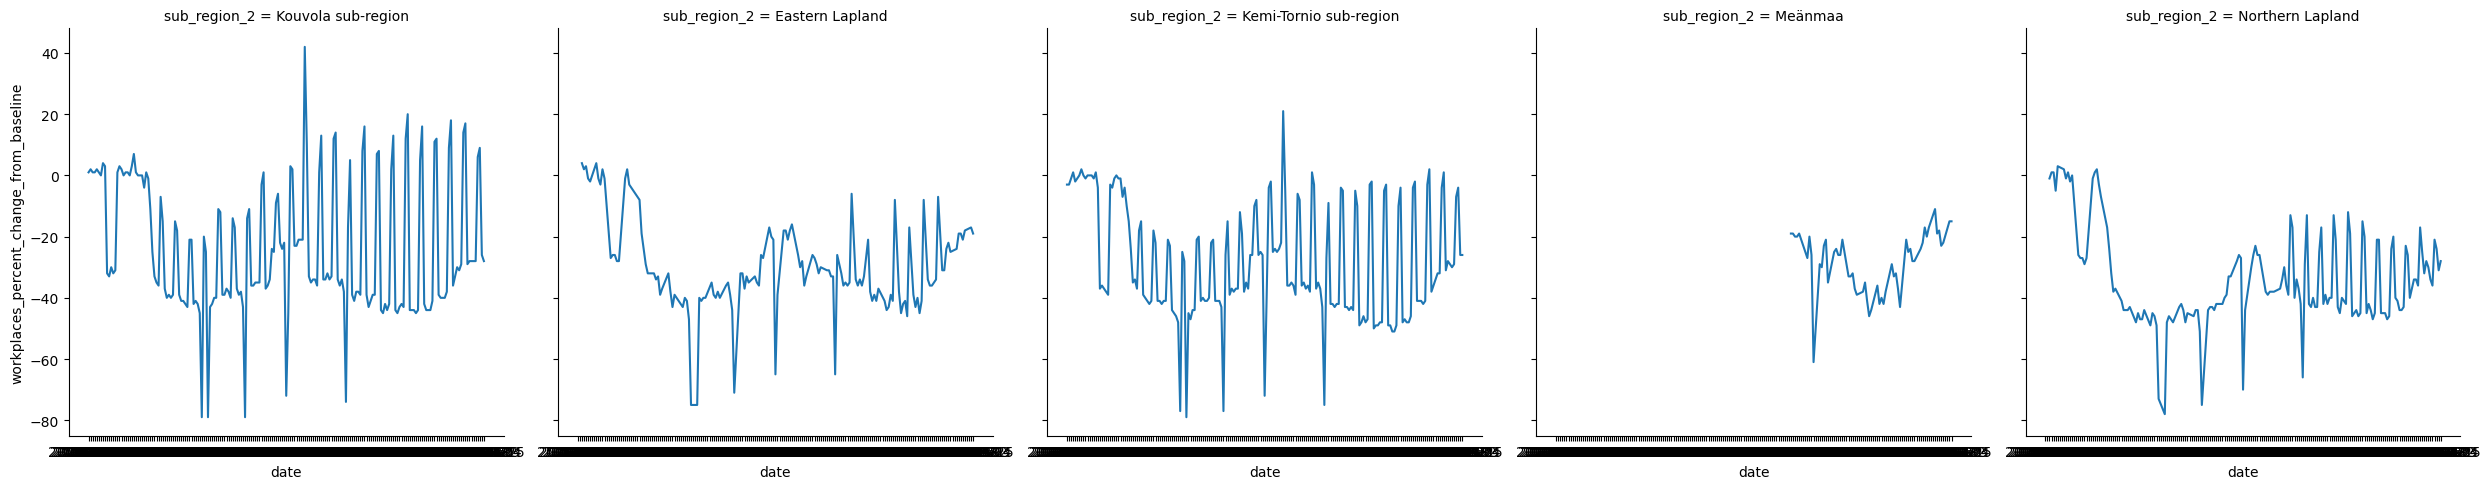

In [22]:
import seaborn as sns
df_region = Global_mobility[Global_mobility['country_region_code']=='FI']
    #df_region = df_region[df_region['sub_region_2'].notna()]
region_5 = df_region.sub_region_2.unique()
if df_region.empty == False:
    sns.relplot(x='date',y='workplaces_percent_change_from_baseline', data=df_region[df_region['sub_region_2'].isin(region_5[1:6])], kind='line', col='sub_region_2')
    sns.relplot(x='date',y='workplaces_percent_change_from_baseline', data=df_region[df_region['sub_region_2'].isin(region_5[6:11])], kind='line', col='sub_region_2')
    sns.relplot(x='date',y='workplaces_percent_change_from_baseline', data=df_region[df_region['sub_region_2'].isin(region_5[11:16])], kind='line', col='sub_region_2')


We observe similar mobility shift among different areas of Finland. The timeline of the shift is consistent with the intervention date of Finland. Also, we observe that the shift volatility seems to differ geographically aming Finland. The variance among regions could be a direction worth investigation. It could be due to the distinction between metropolitan areas and small towns whose population density varies so much that the impact of intervention on mobility shift could be drastic.

## 2.3 For applemobilitytrends-2020-04-20.csv

In [17]:
apple_mobility.head()

,geo_type,region,transportation_type,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,...,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20
0,country/region,Albania,driving,100,95.30,101.43,97.20,103.55,112.67,104.83,...,25.47,24.89,32.64,31.43,30.67,30.00,29.26,22.94,24.55,31.51
1,country/region,Albania,walking,100,100.68,98.93,98.46,100.85,100.13,82.13,...,27.63,29.59,35.52,38.08,35.48,39.15,34.58,27.76,27.93,36.72
2,country/region,Argentina,driving,100,97.07,102.45,111.21,118.45,124.01,95.44,...,19.40,12.89,21.10,22.29,23.55,24.40,27.17,23.19,14.54,26.67
3,country/region,Argentina,walking,100,95.11,101.37,112.67,116.72,114.14,84.54,...,15.75,10.45,16.35,16.66,17.42,18.18,18.80,17.03,10.59,18.44
4,country/region,Australia,driving,100,102.98,104.21,108.63,109.08,89.00,99.35,...,26.95,31.72,53.14,55.91,56.56,58.77,47.51,36.90,53.34,56.93


In [23]:
# check missing value
print('Missing values in total is',apple_mobility.isna().sum().sum())

Missing values in total is 0


In [24]:
# print out regions included in the dataset
print(apple_mobility.region.unique(),apple_mobility.region.nunique())

['Albania' 'Argentina' 'Australia' 'Austria' 'Belgium' 'Brazil' 'Bulgaria'
 'Cambodia' 'Canada' 'Chile' 'Colombia' 'Croatia' 'Czech Republic'
 'Denmark' 'Egypt' 'Estonia' 'Finland' 'France' 'Germany' 'Greece'
 'Hong Kong' 'Hungary' 'Iceland' 'India' 'Indonesia' 'Ireland' 'Israel'
 'Italy' 'Japan' 'Latvia' 'Lithuania' 'Luxembourg' 'Macao' 'Malaysia'
 'Mexico' 'Morocco' 'Netherlands' 'New Zealand' 'Norway' 'Philippines'
 'Poland' 'Portugal' 'Republic of Korea' 'Romania' 'Russia' 'Saudi Arabia'
 'Serbia' 'Singapore' 'Slovakia' 'Slovenia' 'South Africa' 'Spain'
 'Sweden' 'Switzerland' 'Taiwan' 'Thailand' 'Turkey' 'UK' 'United States'
 'Ukraine' 'United Arab Emirates' 'Uruguay' 'Vietnam' 'Amsterdam' 'Athens'
 'Atlanta' 'Auckland' 'Baltimore' 'Bangkok' 'Barcelona' 'Berlin'
 'Birmingham - UK' 'Bochum - Dortmund' 'Boston' 'Brisbane' 'Brussels'
 'Buenos Aires' 'Cairo' 'Calgary' 'Cape Town' 'Chicago' 'Cologne'
 'Copenhagen' 'Dallas' 'Delhi' 'Denver' 'Detroit' 'Dubai' 'Dublin'
 'Dusseldorf' 'Edmo

In [25]:
apple_mobility_1 = apple_mobility
apple_mobility_1 = apple_mobility_1.set_index(['transportation_type','geo_type','region'])
apple_mobility_1 = apple_mobility_1.T
apple_mobility_1.head()

transportation_type,driving,walking,driving,walking,driving,transit,walking,driving,walking,driving,...,transit,walking,driving,walking,driving,transit,walking,driving,transit,walking
geo_type,country/region,country/region,country/region,country/region,country/region,country/region,country/region,country/region,country/region,country/region,...,city,city,city,city,city,city,city,city,city,city
region,Albania,Albania,Argentina,Argentina,Australia,Australia,Australia,Austria,Austria,Belgium,...,Vancouver,Vancouver,Vienna,Vienna,Washington DC,Washington DC,Washington DC,Zurich,Zurich,Zurich
2020-01-13,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,...,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
2020-01-14,95.30,100.68,97.07,95.11,102.98,101.78,101.31,101.14,101.55,101.19,...,93.81,105.24,103.12,103.45,105.82,100.78,99.07,102.38,101.51,106.27
2020-01-15,101.43,98.93,102.45,101.37,104.21,100.64,101.82,104.24,105.59,107.49,...,86.78,91.04,106.60,106.04,109.02,103.92,109.61,110.84,108.93,116.73
2020-01-16,97.20,98.46,111.21,112.67,108.63,99.58,104.52,112.21,112.24,107.67,...,96.86,111.66,126.18,116.05,110.37,105.02,104.16,105.48,97.87,115.31
2020-01-17,103.55,100.85,118.45,116.72,109.08,98.34,113.73,117.23,123.36,117.38,...,104.61,139.11,113.78,128.79,123.98,112.26,123.16,113.83,103.91,118.22


In [26]:
driving = apple_mobility_1['driving']
walking = apple_mobility_1['walking']
transit = apple_mobility_1['transit']

Walking shift

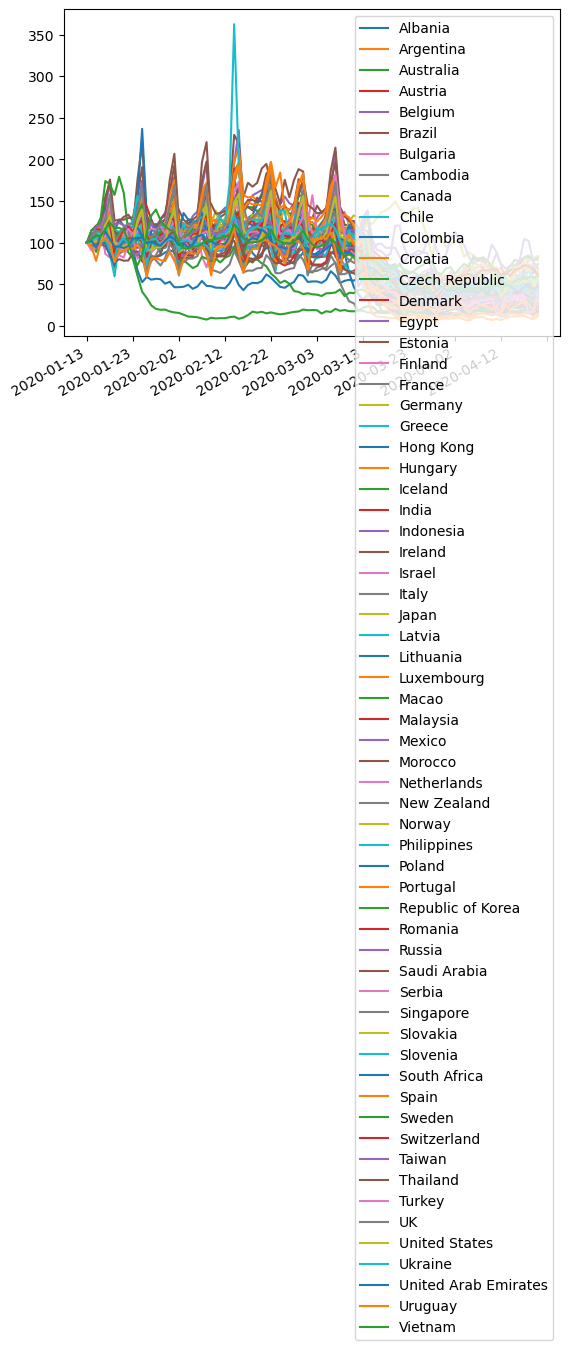

In [27]:
import matplotlib.ticker as ticker
fig, ax = plt.subplots(1,1)
ax.plot(apple_mobility_1['walking']['country/region'])
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10))
ax.legend(apple_mobility_1['walking']['country/region'].columns, loc = 0)
fig.autofmt_xdate()
plt.show()


Driving shift

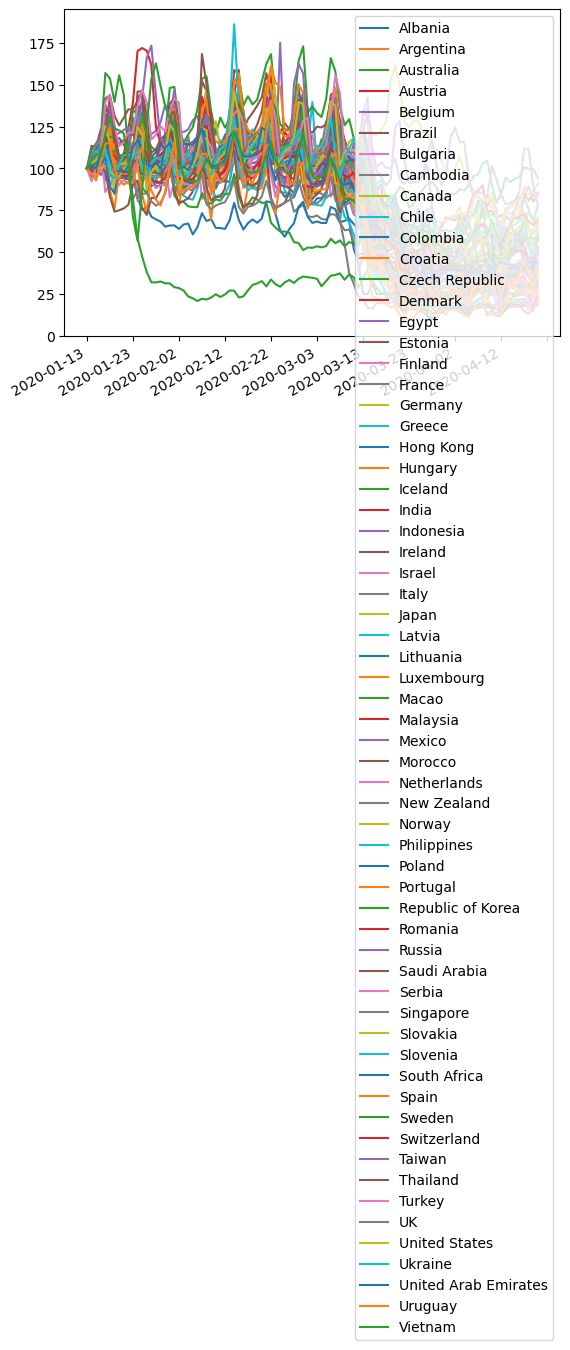

In [28]:
fig, ax = plt.subplots(1,1)
ax.plot(apple_mobility_1['driving']['country/region'])
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10))
ax.legend(apple_mobility_1['driving']['country/region'].columns, loc = 0)
fig.autofmt_xdate()
plt.show()

Transit shift

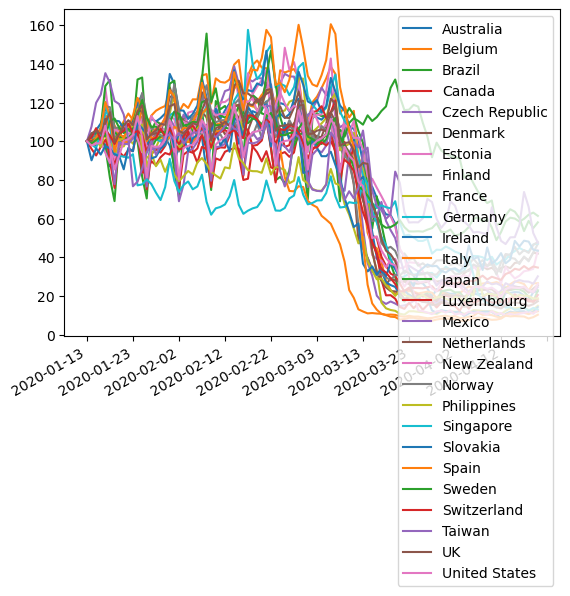

In [29]:
import matplotlib.ticker as ticker
fig, ax = plt.subplots(1,1)
ax.plot(apple_mobility_1['transit']['country/region'])
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10))
ax.legend(apple_mobility_1['transit']['country/region'].columns, loc = 0)
fig.autofmt_xdate()
plt.show()

<AxesSubplot:>

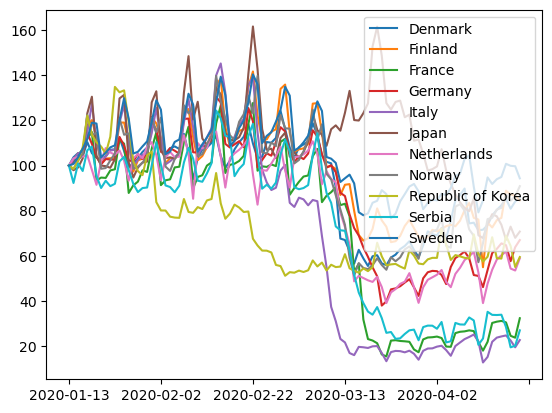

In [30]:
#plot line chart for every activity (driving as an example first) for country in interventions.csv
driving = apple_mobility.loc[apple_mobility['transportation_type'] == 'driving']
driving = driving[driving['region'].isin(['France','Denmark','Germany','Italy','Netherlands','Norway','Serbia','Sweden','Republic of Korea','Finland','Japan']) ]

new_driving = driving.iloc[:, 3:]
driving_matrix  = new_driving.T.to_numpy()
df_legend = driving.iloc[:, 1].to_numpy()

df = pd.DataFrame(list(driving_matrix),
                 index = new_driving.columns[:].to_numpy() , 
                columns = df_legend) #df_legend[1:]
df.plot()

In [31]:
# Implementation strength can be expressed in terms of the frequency of occurrence of various activities in the post-reduction stabilisation phase.
min_mobility = pd.DataFrame(df.min())
min_mobility

,0
Denmark,55.46
Finland,54.91
France,15.33
Germany,37.90
Italy,12.66
Japan,67.08
Netherlands,38.99
Norway,51.20
Republic of Korea,51.12
Serbia,19.39


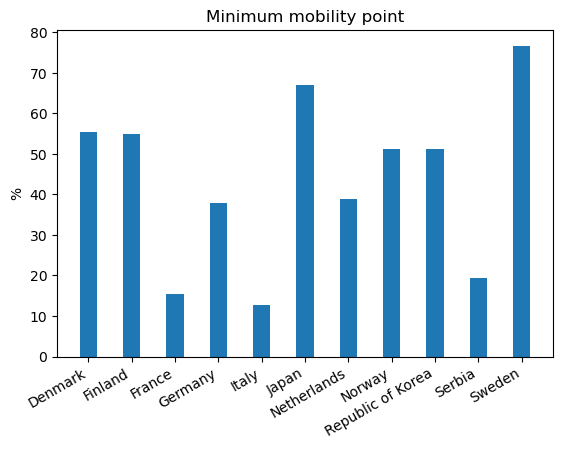

In [32]:
#Plot the implementation strengt
x_axis = min_mobility.index
y_min = min_mobility[0]
fig = plt.figure()
plt.bar(x_axis, y_min, width=0.4)

#plt.xticks(x_axis,rotation = 45)
plt.title('Minimum mobility point')
#plt.xlabel('Country')
plt.ylabel('%')
fig.autofmt_xdate()
plt.show()

In all three kinds of mobility methods, we observe similar fluctuations in the trend of mobility shift. There are fluctuations and no obvious trend before 2020 March. During 2020 March, a country-universal downward shift happened and the activeness of walking, driving and public transportation decreased tremendously to as low as 20%. In this case, the mobility methods don't demonstrate substitude traits for each other but rather complementary traits. We could do further regression analysis on the issue accompanied with external data to generate extensive conclusion.

3.Further statistical analysis for the dataset

3.1 We could **run regression** on the speed the government takes actions (Here is denoted as $d_{response}$ the days between first death date and first restriction date) and the stickiness of the mobility shift due to the government restriction which is denoted as the mobility shift after one month of the mobility change.
Here we need more data..

3.2 Manually extract features such as restriction dates (dummy variable), continent which the country belong to, size of the country, .. to do machine learning, divide train set and test set and see the learning results.
